In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from zipfile import ZipFile
file_name1 = '/content/drive/MyDrive/CT_COVID.zip'
file_name2 = '/content/drive/MyDrive/CT_NonCOVID.zip'
with ZipFile(file_name1,'r') as zzz:
  zzz.extractall()
with ZipFile(file_name2,'r') as zzz:
  zzz.extractall()
  print('Done')

Done


In [3]:
file_name = '/content/drive/MyDrive/NewData.zip'
with ZipFile(file_name,'r') as zzz:
  zzz.extractall()

In [4]:
!cp /content/NewData/CT_COVID/1252_png/* /content/NewData/CT_COVID/
!cp /content/NewData/CT_COVID/275_png/* /content/NewData/CT_COVID/
!cp /content/NewData/CT_COVID/349_png/* /content/NewData/CT_COVID/

In [5]:
!cp /content/NewData/CT_NonCOVID/1229_png/* /content/NewData/CT_NonCOVID/
!cp /content/NewData/CT_NonCOVID/397_jpg+png/* /content/NewData/CT_NonCOVID/

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# customary imports:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import glob
import os
import tqdm
from sklearn.model_selection import StratifiedKFold



(2870, 224, 224) (2870, 2)
(718, 224, 224) (718, 2)


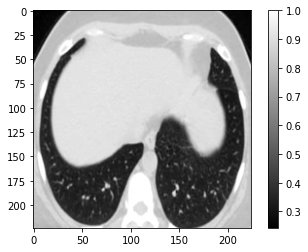

In [7]:
# customary imports:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import glob
import os
import tqdm
from sklearn.model_selection import StratifiedKFold

def load_and_crop(image_path, crop_size, normalized=True):
    image = Image.open(image_path).resize([crop_size,crop_size])
    width, height = image.size   # Get dimensions
    left = (width - crop_size)/2
    top = (height - crop_size)/2
    right = (width + crop_size)/2
    bottom = (height + crop_size)/2
    # Crop the center of the image
    image = ImageOps.grayscale(image.crop((left, top, right, bottom)))
    if normalized:
        return np.array(image).astype(np.float32) / 255.0
    else:
        return np.array(image).astype(np.float32)

results = ['CT_COVID','CT_NonCOVID']
result_inds = np.arange(0, len(results))
x_data = []
y_data = []
for result_ind in result_inds:
    all_images = glob.glob(os.path.join('', results[result_ind], '*.png'))
    x_data += [load_and_crop(image_path, 224) for image_path in all_images]
    y_data += [result_ind]*len(all_images)

for result_ind in result_inds:
    all_images = glob.glob(os.path.join('NewData', results[result_ind], '*.png'))
    x_data += [load_and_crop(image_path, 224) for image_path in all_images]
    y_data += [result_ind]*len(all_images)
    
# adding a fake color channel
folder = StratifiedKFold(5, shuffle=True)
x_indices = np.arange(0, len(x_data))
train_indices, val_indices = folder.split(x_indices, y_data).__next__()
# shuffling
np.random.shuffle(train_indices)

x_data = np.array(x_data)
y_data = np.array(y_data)

x_train = x_data[train_indices]
y_train = np.eye(len(results))[y_data[train_indices]]

x_val = x_data[val_indices]
y_val = np.eye(len(results))[y_data[val_indices]]

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

plt.imshow(x_train[0,:,:],cmap = "gray")
plt.colorbar()

In [8]:
x_data[0].shape

(224, 224)

In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

x_test = x_val
y_test = y_val
y_test = np.argmax(y_test, axis=-1)
y_train = np.argmax(y_train, axis=-1)
x_train, x_test = x_train / 255.0, x_test / 255.0  # customary normalization to [0, 1]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(2870, 224, 224) (2870,)
(718, 224, 224) (718,)


In [10]:
wavelength = .5
def convert_images(X):
    sample_phase = X
    optical_thickness = 1 * wavelength
    sample = np.exp(1j * sample_phase*optical_thickness/wavelength)
    return sample

x_train = convert_images(x_train)
x_test = convert_images(x_test)

In [11]:
x_train[0,:,:].shape

(224, 224)

In [12]:
#y_train = np.array([y_train]).T

In [13]:
#y_test = np.array([y_test]).T

In [14]:

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [15]:

input_illumination_phase = tf.Variable(initial_value=np.zeros([224,224]), dtype='float32',trainable=True)

radius = 150
fx = np.linspace(-100,100,224)
fy = np.linspace(-100,100,224)
[fxx,fyy] = np.meshgrid(fx,fy)
circ_aper = tf.Variable(initial_value=(np.sqrt(fxx**2+fyy**2)< radius),dtype='float32',trainable=True)
aperture_phase = tf.Variable(initial_value=np.zeros([224,224]), name='aperture_phase', dtype='float32',trainable=True)


In [16]:
def physical_layer(x_batch):
  field0 = tf.math.multiply(tf.exp(1j*tf.cast(input_illumination_phase,dtype=tf.complex64)), tf.cast(x_batch,dtype=tf.complex64))
  field0 = tf.cast(field0, dtype=tf.complex64)
  field1 = tf.signal.fft2d(field0)
  field2 = tf.cast(tf.signal.fftshift(field1),dtype=tf.complex64)
  apt = tf.exp(1j*tf.cast(aperture_phase,tf.complex64))
  image0 = tf.math.multiply(field2, apt)
  image1 = tf.math.multiply(image0, tf.cast(circ_aper,dtype=tf.complex64))
  image2 = tf.signal.fftshift(image1)
  image3 = tf.cast(tf.signal.ifft2d(image2),dtype=tf.complex64)
  image = tf.cast(tf.abs(image3)**2, dtype=tf.float32)
  noise_sig = 0
  shape = (224,224)
  image += tf.random.normal(shape, 0, noise_sig, dtype=tf.float32)

  image = image[..., tf.newaxis]

  return image-1

In [17]:
from tensorflow.keras.layers import *

In [18]:
class CNN(tf.keras.Model):
  def __init__(self):
    super(CNN, self).__init__()
    self.steps = []
    self.steps.append(Conv2D(64, 5, strides =1, padding ="same", activation='relu'))
    self.steps.append(Conv2D(64, 5, strides =2, padding ="same", activation='relu'))
    self.steps.append(BatchNormalization())
    self.steps.append(MaxPool2D(2))
    self.steps.append(Conv2D(128, 5, strides =1, padding ="same", activation='relu'))
    self.steps.append(Conv2D(128, 5, strides =2, padding ="same", activation='relu'))
    self.steps.append(BatchNormalization())
    self.steps.append(MaxPool2D(2))
    self.steps.append(Conv2D(256, 5, strides =1, padding ="same", activation='relu'))
    self.steps.append(Conv2D(256, 5, strides =2, padding ="same", activation='relu'))
    self.steps.append(BatchNormalization())
    self.steps.append(MaxPool2D(2))
    self.steps.append(Flatten())
    self.steps.append(Dense(256, activation='relu'))
    self.steps.append(Dense(10, activation='softmax'))
    self.steps.append(Dense(1, activation='sigmoid'))
  def call(self, x):
    for s in self.steps:
      x = s(x)
    return x
  
model = CNN()


In [19]:
loss_object = tf.keras.losses.BinaryCrossentropy()

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy')

In [20]:
# the full forward model, which includes both the physical layer and the CNN model:
def forward_model(x_batch):
  p_layer_out = physical_layer(x_batch)
  return model(p_layer_out)

In [21]:
# train loop
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    predictions = forward_model(images)
    loss = loss_object(labels, predictions)
  trainV = model.trainable_variables
  trainV.append(aperture_phase)
  trainV.append(input_illumination_phase)
  gradients = tape.gradient(loss, trainV)
  optimizer.apply_gradients(zip(gradients, trainV))

  train_loss(loss)
  train_accuracy(labels, predictions)

@tf.function
def test_step(images, labels):
  predictions = forward_model(images)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

EPOCHS = 20

for epoch in range(EPOCHS):
  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
  print (template.format(epoch+1,
                         train_loss.result(),
                         train_accuracy.result()*100,
                         test_loss.result(),
                         test_accuracy.result()*100))
    # Reset the metrics for the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

Epoch 1, Loss: 0.6887935400009155, Accuracy: 54.92424392700195, Test Loss: 0.6965035796165466, Test Accuracy: 53.53260803222656
Epoch 2, Loss: 0.6900964379310608, Accuracy: 54.9084587097168, Test Loss: 0.6922698020935059, Test Accuracy: 53.53260803222656
Epoch 3, Loss: 0.6887845396995544, Accuracy: 54.8453254699707, Test Loss: 0.6916647553443909, Test Accuracy: 53.53260803222656
Epoch 4, Loss: 0.6884713172912598, Accuracy: 54.87689208984375, Test Loss: 0.691192090511322, Test Accuracy: 53.53260803222656
Epoch 5, Loss: 0.688499391078949, Accuracy: 54.86111068725586, Test Loss: 0.6911070346832275, Test Accuracy: 53.53260803222656
Epoch 6, Loss: 0.688434898853302, Accuracy: 54.87689208984375, Test Loss: 0.6910573840141296, Test Accuracy: 53.53260803222656
Epoch 7, Loss: 0.6883608102798462, Accuracy: 54.92424392700195, Test Loss: 0.6909658908843994, Test Accuracy: 53.53260803222656
Epoch 8, Loss: 0.688467800617218, Accuracy: 54.86111068725586, Test Loss: 0.6911094188690186, Test Accuracy: 

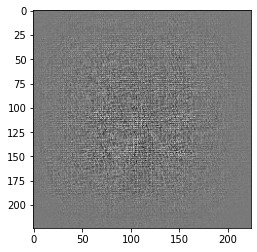

In [22]:

plt.imshow(input_illumination_phase.numpy(),cmap = 'gray')

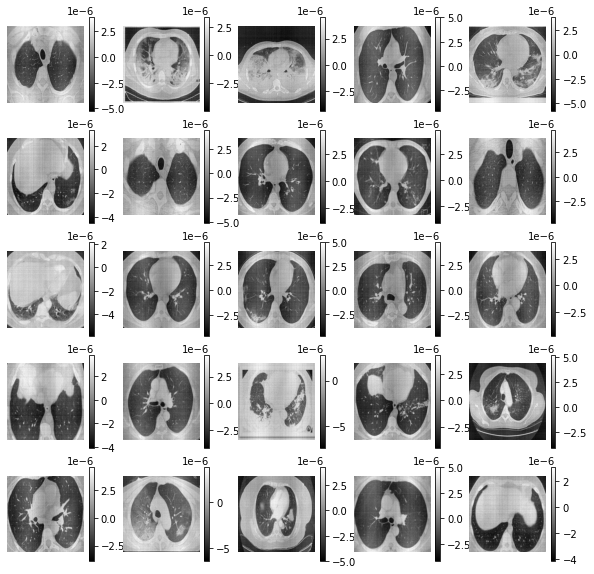

In [23]:
def plot_examples(batch):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(batch[i, :, :, 0],cmap = "gray")
        plt.colorbar()
        plt.axis('off')
    plt.show()

plot_examples(physical_layer(x_train[:25]).numpy())

In [24]:
from keras.optimizers import SGD, Adam

import tensorflow.keras.applications as app
from tensorflow.keras.models import Sequential,Model

In [25]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [26]:
from keras import applications
from keras import optimizers
from keras.models import Sequential,Model,load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D
from keras.optimizers import SGD, Adam

In [27]:

resnet = applications.resnet50.ResNet50(weights= None, include_top=False, input_shape= (224,224,3))
x = resnet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(2, activation= 'softmax')(x)
model = Model(inputs = resnet.input, outputs = predictions)

# sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
adam = Adam(lr=0.0001)
model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
x_data_3d = np.array([np.stack((i,)*3, axis=-1) for i in x_data ])

In [29]:
x_train_3d = x_data_3d[train_indices]
y_train_3d = np.eye(len(results))[y_data[train_indices]]

x_val_3d = x_data_3d[val_indices]
y_val_3d = np.eye(len(results))[y_data[val_indices]]

In [30]:
#https://github.com/tensorflow/tensorflow/blob/v2.3.1/tensorflow/python/keras/applications/resnet.py#L456-L475
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [43]:

res_res = model.fit(x_train_3d, y_train_3d, epochs = 30, batch_size = 64)

plt.plot(res_res.history['loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["train", "test"], loc="upper right")
plt.show()
plt.plot(res_res.history['accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Acc")
plt.xlabel("Epoch")
plt.legend(["train", "test"], loc="upper right")
plt.show()

Epoch 1/30
45/45 [==============================] - 9s 198ms/step - loss: 0.2645 - accuracy: 0.9115
Epoch 2/30
45/45 [==============================] - 9s 198ms/step - loss: 0.1551 - accuracy: 0.9463
Epoch 3/30
45/45 [==============================] - 9s 198ms/step - loss: 0.2022 - accuracy: 0.9366
Epoch 4/30
45/45 [==============================] - 9s 199ms/step - loss: 0.1640 - accuracy: 0.9422
Epoch 5/30
45/45 [==============================] - 9s 199ms/step - loss: 0.1525 - accuracy: 0.9422
Epoch 6/30
45/45 [==============================] - 9s 198ms/step - loss: 0.1403 - accuracy: 0.9481
Epoch 7/30
45/45 [==============================] - 9s 198ms/step - loss: 0.1594 - accuracy: 0.9523
Epoch 8/30
45/45 [==============================] - 9s 198ms/step - loss: 0.0872 - accuracy: 0.9683
Epoch 9/30
45/45 [==============================] - 9s 199ms/step - loss: 0.0633 - accuracy: 0.9749
Epoch 10/30
 5/45 [==>...........................] - ETA: 7s - loss: 0.1399 - accuracy: 0.9625

KeyboardInterrupt: ignored

In [44]:
preds = model.evaluate(x_val_3d, y_val_3d)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

23/23 [==============================] - 1s 37ms/step - loss: 1.3573 - accuracy: 0.7479
Loss = 1.3573130369186401
Test Accuracy = 0.7479108572006226


In [ ]:
np.argmax(model.predict(x_val_3d[100:164]), axis=1)